In [1]:
# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# calculating
import xarray as xr                        
import numpy as np 
import pandas as pd
from datetime import datetime

# regridding
import xesmf as xe

In [2]:
omi_mls_ds = xr.open_dataarray("/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_300hpa_monthly_mean_2005_2024_full.nc")
omi_mls_ds = omi_mls_ds.rename({'latitude': 'lat', 'longitude': 'lon'})

# shifting lon to be 0-360
omi_mls_ds['lon'] = omi_mls_ds['lon'] % 360
omi_mls_ds = omi_mls_ds.sortby('lon')

In [3]:
cesm_output = xr.open_dataarray("/glade/u/home/mvoncyga/SOARS_2025/300hPa_tco_cesm_monthly.nc")

In [4]:
regridder = xe.Regridder(cesm_output, omi_mls_ds, 'bilinear', periodic=True) 
cesm_regridded = regridder(cesm_output)

In [5]:
dataset = xr.open_dataset("tco300_omimls_oct2004_to_dec2024_1by1.nc")
ozone = dataset["TropoO3"]
ozone = ozone.where(ozone >= 0)


# adding month from attributes to coordinate
month = ozone.attrs['Month'].split(',')
first_month = month[0]                              # October 2004
last_month = month[-1].replace(' ', '')             # December 2024

start_date = datetime.strptime(first_month, "%b%Y")
end_date = datetime.strptime(last_month, "%b%Y")
time_coords = pd.date_range(start=start_date, end=end_date, freq='MS')


# renaming and assigning/removing dimensions
ozone = ozone.assign_coords(time=('months', time_coords))
ozone = ozone.rename({"time": "yearmonth",'y_elements': 'latitude', 'x_elements': 'longitude'})
ozone = ozone.swap_dims({'months': 'yearmonth'})


# select date range based on what you want to plot
start_date = '2005-01-01'
end_date = '2024-12-01'
ozone_subsetted = ozone.sel(yearmonth=slice(start_date, end_date))


# adding lat/lon from attributes to coordinates
lat_coords = ozone_subsetted.attrs['latitude'].split(',')
first_lat = float(lat_coords[0])
last_lat = float(lat_coords[-1])

lon_coords = ozone_subsetted.attrs['longitude'].split(',')
first_lon = float(lon_coords[0])
last_lon = float(lon_coords[-1])

lon_coords = np.arange(first_lon, 180.5, 1)
lat_coords = np.arange(first_lat,90.5, 1)

ozone_subsetted = ozone_subsetted.assign_coords(
    longitude=('longitude', lon_coords),
    latitude=('latitude', lat_coords)
)

In [6]:
ozone_subsetted = ozone_subsetted.transpose('yearmonth', 'longitude', 'latitude')
cesm_regridded = cesm_regridded.transpose('time','lon','lat')

In [48]:
# create binned subsets, this case 4 degree bins

bins = np.arange(-89.5, 90.5, step=2)

binned_ozone_subsetted = ozone_subsetted.groupby_bins('latitude', bins).mean()
binned_cesm_regridded = cesm_regridded.groupby_bins('lat', bins).mean()

In [49]:
# group by seasons

binned_seasonal_omi_mls_mean = binned_ozone_subsetted.groupby('yearmonth.season').mean('yearmonth')
binned_seasonal_cesm_regridded = binned_cesm_regridded.groupby('time.season').mean('time')

In [50]:
rmse_omi_mls = np.sqrt(((binned_seasonal_omi_mls_mean - binned_seasonal_omi_mls_mean.mean(axis=0))**2).mean(axis=1))
rmse_cesm = np.sqrt(((binned_seasonal_cesm_regridded - binned_seasonal_cesm_regridded.mean(axis=0))**2).mean(axis=1))

In [51]:
# average out by longitude

binned_seasonal_omi_mls_mean = binned_seasonal_omi_mls_mean.mean('longitude')
binned_seasonal_cesm_regridded = binned_seasonal_cesm_regridded.mean('lon')

In [54]:
latitudes = np.arange(-89.5, 84.5, step=4)
seasonal_list = ['DJF', 'JJA', 'MAM', 'SON']

89

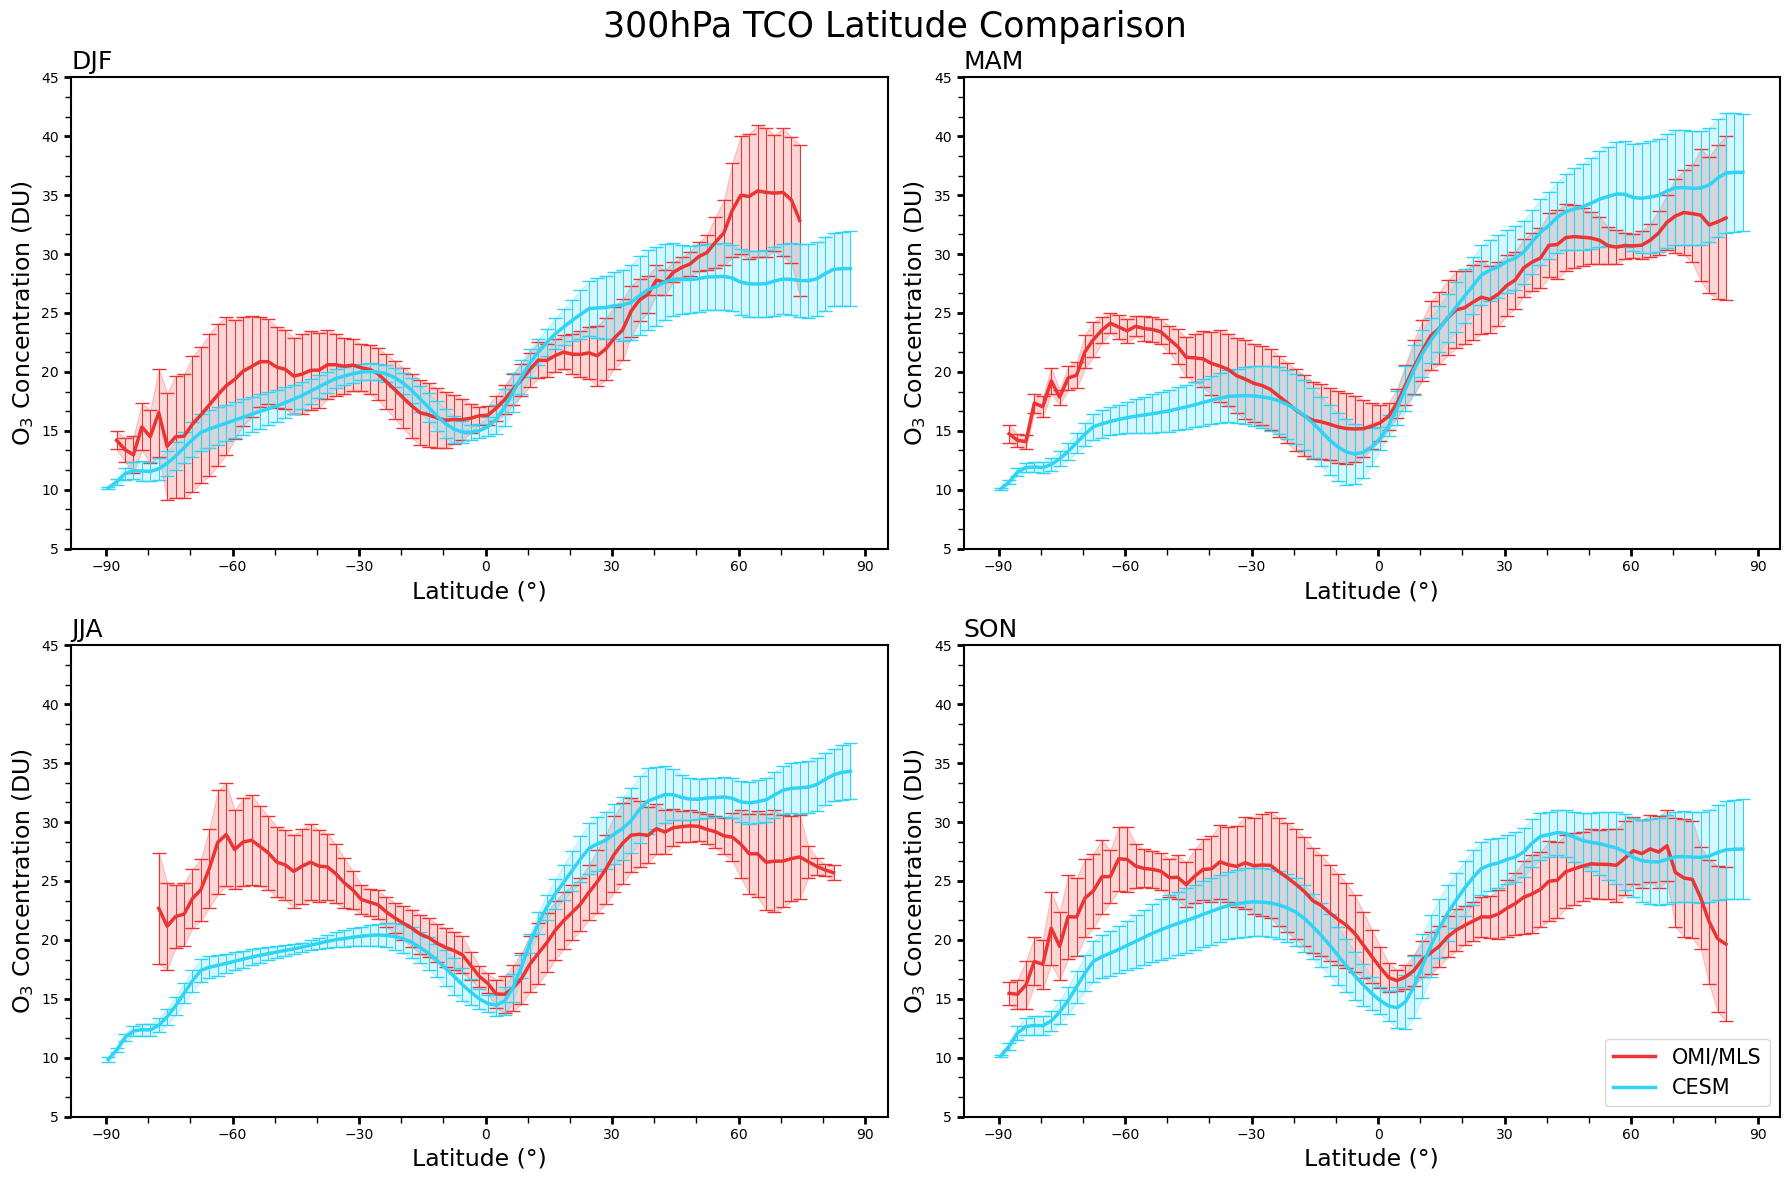

In [56]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,12))

for axis in ['top','bottom','left','right']:
    for i in range(2):
        for j in range(2):
            ax[i][j].spines[axis].set_linewidth(1.5)

for i in range(2):
        for j in range(2):
                ax[i][j].spines[axis].set_linewidth(1.5)
                ax[i][j].set_ylabel("$\mathregular{O_3}$ Concentration (DU)", fontsize=17)
                ax[i][j].set_xlabel("Latitude (°)", fontsize=17)
                ax[i][j].set_ylim(5,45)
                ax[i][j].set_xticks([-90,-60,-30,0,30,60,90])
                ax[i][j].xaxis.set_minor_locator(AutoMinorLocator(3))
                ax[i][j].yaxis.set_minor_locator(AutoMinorLocator(3))
                ax[i][j].tick_params(which='major', width=2)
                ax[i][j].tick_params(which='minor', width=1)
                ax[i][j].tick_params(which='major', length=5)
                ax[i][j].tick_params(which='minor', length=4)


ax[0][0].set_title(str(seasonal_list[0]), fontsize=18, loc='left')
ax[0][0].errorbar(latitudes, binned_seasonal_omi_mls_mean[0], yerr=rmse_omi_mls[0], elinewidth=0.75, ecolor='#eb3434', fmt='none', capsize=5, errorevery=i)
ax[0][0].errorbar(latitudes, binned_seasonal_cesm_regridded[0], yerr=rmse_cesm[0], elinewidth=0.75, ecolor='#2fd4f5', fmt='none', capsize=5, errorevery=i)
ax[0][0].plot(latitudes, binned_seasonal_omi_mls_mean[0], color='#eb3434', linewidth=2.5)
ax[0][0].plot(latitudes, binned_seasonal_cesm_regridded[0], color='#2fd4f5', linewidth=2.5)
ax[0][0].fill_between(latitudes, binned_seasonal_omi_mls_mean[0]-rmse_omi_mls[0], binned_seasonal_omi_mls_mean[0]+rmse_omi_mls[0], color='#eb3434', alpha=0.2)
ax[0][0].fill_between(latitudes, binned_seasonal_cesm_regridded[0]-rmse_cesm[0], binned_seasonal_cesm_regridded[0]+rmse_cesm[0], color='#2fd4f5', alpha=0.2)


ax[1][0].set_title(str(seasonal_list[1]), fontsize=18, loc='left')
ax[1][0].errorbar(latitudes, binned_seasonal_omi_mls_mean[1], yerr=rmse_omi_mls[1], elinewidth=0.75, ecolor='#eb3434', fmt='none', capsize=5, errorevery=i)
ax[1][0].errorbar(latitudes, binned_seasonal_cesm_regridded[1], yerr=rmse_cesm[1], elinewidth=0.75, ecolor='#2fd4f5', fmt='none', capsize=5, errorevery=i)
ax[1][0].plot(latitudes, binned_seasonal_omi_mls_mean[1], color='#eb3434', linewidth=2.5)
ax[1][0].plot(latitudes, binned_seasonal_cesm_regridded[1], color='#2fd4f5', linewidth=2.5)
ax[1][0].fill_between(latitudes, binned_seasonal_omi_mls_mean[1]-rmse_omi_mls[1], binned_seasonal_omi_mls_mean[1]+rmse_omi_mls[1], color='#eb3434', alpha=0.2)
ax[1][0].fill_between(latitudes, binned_seasonal_cesm_regridded[1]-rmse_cesm[1], binned_seasonal_cesm_regridded[1]+rmse_cesm[1], color='#2fd4f5', alpha=0.2)


ax[0][1].set_title(str(seasonal_list[2]), fontsize=18, loc='left')
ax[0][1].errorbar(latitudes, binned_seasonal_omi_mls_mean[2], yerr=rmse_omi_mls[2], elinewidth=0.75, ecolor='#eb3434', fmt='none', capsize=5, errorevery=i)
ax[0][1].errorbar(latitudes, binned_seasonal_cesm_regridded[2], yerr=rmse_cesm[2], elinewidth=0.75, ecolor='#2fd4f5', fmt='none', capsize=5, errorevery=i)
ax[0][1].plot(latitudes, binned_seasonal_omi_mls_mean[2], color='#eb3434', linewidth=2.5)
ax[0][1].plot(latitudes, binned_seasonal_cesm_regridded[2], color='#2fd4f5', linewidth=2.5)
ax[0][1].fill_between(latitudes, binned_seasonal_omi_mls_mean[2]-rmse_omi_mls[2], binned_seasonal_omi_mls_mean[2]+rmse_omi_mls[2], color='#eb3434', alpha=0.2)
ax[0][1].fill_between(latitudes, binned_seasonal_cesm_regridded[2]-rmse_cesm[2], binned_seasonal_cesm_regridded[2]+rmse_cesm[2], color='#2fd4f5', alpha=0.2)


ax[1][1].set_title(str(seasonal_list[3]), fontsize=18, loc='left')
ax[1][1].errorbar(latitudes, binned_seasonal_omi_mls_mean[3], yerr=rmse_omi_mls[3], elinewidth=0.75, ecolor='#eb3434', fmt='none', capsize=5, errorevery=i)
ax[1][1].errorbar(latitudes, binned_seasonal_cesm_regridded[3], yerr=rmse_cesm[3], elinewidth=0.75, ecolor='#2fd4f5', fmt='none', capsize=5, errorevery=i)
ax[1][1].plot(latitudes, binned_seasonal_omi_mls_mean[3], color='#eb3434', linewidth=2.5)
ax[1][1].plot(latitudes, binned_seasonal_cesm_regridded[3], color='#2fd4f5', linewidth=2.5)
ax[1][1].fill_between(latitudes, binned_seasonal_omi_mls_mean[3]-rmse_omi_mls[3], binned_seasonal_omi_mls_mean[3]+rmse_omi_mls[3], color='#eb3434', alpha=0.2)
ax[1][1].fill_between(latitudes, binned_seasonal_cesm_regridded[3]-rmse_cesm[3], binned_seasonal_cesm_regridded[3]+rmse_cesm[3], color='#2fd4f5', alpha=0.2)

fig.suptitle('300hPa TCO Latitude Comparison', fontsize=25)
plt.tight_layout()
plt.legend(['OMI/MLS', 'CESM'], loc='lower right', prop={'size':  15})

#plt.savefig("figures/300hPa_Latitude_Comparison_4DegBins")
plt.show()